In [1]:
!pip install pyLDAvis
!pip install pandas --upgrade

** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **

In [2]:
# Importing modules
import pandas as pd

# Read data into papers
papers = pd.read_csv('data/tweets_labelled_sastrawi.csv')

# Print head
papers.head()

,tweet,polaritas,sentimen
0,jbharga ayam rm tgk telor wyam papan rm...,-2,Negatif
1,diri di atas kaki sendiri serap telur t...,-2,Negatif
2,sebab harga telur anjlok versi dagang kaget,5,Positif
3,turun minta masyarakat telur ayam ppkm l...,-1,Negatif
4,ternak ayam telur aku rugi ratus juta r...,5,Positif


In [3]:
print("Banyaknya data : ",len(papers)," data")

Banyaknya data :  2879  data


** **
#### Step 2: Data Cleaning <a class="anchor\" id="clean_data"></a>
** **

In [4]:
# Remove the columns
papers = papers.drop(columns=['polaritas', 'sentimen'], axis=1).sample(100)

# Print out the first rows of papers
print(papers.head())

                                                  tweet
2099  dagel  politik  harga  telur  bang  pakan  aya...
1452  suroto  ternak  ayam  blitar  aksi  protes  pr...
2582  beli  indomie  varian  hari  total  butuh  bun...
1027  puluh  ternak  ayam  telur  magetan  bagi  tel...
851   harga  telur  ternak  rendah  integrator  eks ...


In [5]:
# Load the regular expression library
import re

# Remove punctuation
papers['tweet_processed'] = \
papers['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['tweet_processed'] = \
papers['tweet_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
print(papers['tweet_processed'].head())

2099    dagel  politik  harga  telur  bang  pakan  aya...
1452    suroto  ternak  ayam  blitar  aksi  protes  pr...
2582    beli  indomie  varian  hari  total  butuh  bun...
1027    puluh  ternak  ayam  telur  magetan  bagi  tel...
851     harga  telur  ternak  rendah  integrator  eks ...
Name: tweet_processed, dtype: object


** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

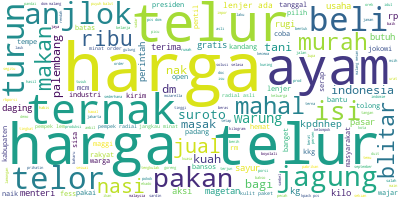

In [6]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['tweet_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

In [7]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('indonesian')
stop_words.extend(['yg', 'yang', 'gak', 'ga', 'nya', 'yaa', 'tp', 'aja', 'tp', 'unt', 'sih','gtu','gitu','ya','utk','jg','kalo','klo','udh'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.tweet_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['dagel', 'politik', 'harga', 'telur', 'bang', 'pakan', 'ayam', 'murah', 'jagung', 'kedelai', 'import', 'minum', 'formula', 'sehat']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ANZ007\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

In [9]:
from pprint import pprint

# number of topics
num_topics = 7

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.074*"harga" + 0.051*"telur" + 0.026*"ternak" + 0.020*"ayam" + '
  '0.015*"pakan" + 0.014*"jagung" + 0.012*"beli" + 0.011*"blitar" + '
  '0.011*"kkg" + 0.011*"mahal"'),
 (1,
  '0.090*"harga" + 0.048*"telur" + 0.030*"ayam" + 0.016*"turun" + '
  '0.015*"ternak" + 0.012*"jagung" + 0.010*"anjlok" + 0.010*"telor" + '
  '0.009*"kuah" + 0.009*"terima"'),
 (2,
  '0.057*"harga" + 0.052*"telur" + 0.021*"ternak" + 0.014*"telor" + '
  '0.013*"isi" + 0.012*"jagung" + 0.011*"blitar" + 0.010*"turun" + '
  '0.010*"lupa" + 0.010*"rm"'),
 (3,
  '0.054*"harga" + 0.054*"telur" + 0.024*"pempek" + 0.024*"lenjer" + '
  '0.019*"ayam" + 0.017*"palembang" + 0.016*"telor" + 0.015*"asli" + '
  '0.014*"kulit" + 0.011*"anjlok"'),
 (4,
  '0.086*"telur" + 0.079*"harga" + 0.028*"ayam" + 0.023*"ternak" + 0.021*"isi" '
  '+ 0.017*"beli" + 0.016*"turun" + 0.014*"nasi" + 0.012*"murah" + '
  '0.011*"anjlok"'),
 (5,
  '0.037*"ayam" + 0.035*"harga" + 0.032*"telur" + 0.020*"makan" + '
  '0.014*"menteri" + 0.009*"hasi

** **
#### Step 6: Analyzing our LDA model <a class="anchor\" id="results"></a>
** **

In [10]:
import pyLDAvis
import pyLDAvis.gensim_models
import pickle
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('data/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'data/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

F:\Apps-Files\Windows\Miniconda\envs\data-mining\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.040869  0.079632       1        1  22.946199
1     -0.035218 -0.088276       2        1  18.415153
0     -0.055603 -0.000481       3        1  17.487839
3      0.148959 -0.006172       4        1  14.252429
6     -0.026076 -0.049187       5        1  14.003022
2     -0.001328  0.078335       6        1   7.971591
5      0.010137 -0.013849       7        1   4.923767, topic_info=         Term       Freq      Total Category  logprob  loglift
0        ayam  35.000000  35.000000  Default  30.0000  30.0000
137    pempek   5.000000   5.000000  Default  29.0000  29.0000
132    lenjer   5.000000   5.000000  Default  28.0000  28.0000
114     makan   6.000000   6.000000  Default  27.0000  27.0000
10      pakan  10.000000  10.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
376  malaysia   0.490600   1.832620   Topic7  -4.9207   1.6932
218    rakyat   0.490584   2.303450   Topic7  -4.9207   1.4645
475    gulung   0.490548   1.870393   Topic7  -4.9208   1.6727
382    sardin   0.490534   1.917299   Topic7  -4.9208   1.6479
374      ikan   0.490521   1.917229   Topic7  -4.9208   1.6479

[376 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
272       1  0.693877    adha
246       1  0.693868     air
14        1  0.264297    aksi
14        2  0.264297    aksi
14        3  0.264297    aksi
...     ...       ...     ...
73        5  0.396581  warung
196       1  0.693864    well
32        2  0.727864     wib
305       3  0.672052    wktu
551       3  0.672057   yasin

[386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 7, 3, 6])